In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torch.utils.data as td
import json
import math
import matplotlib.pyplot as plt
import onnx
import onnx.numpy_helper
import torchvision.transforms as xf
import random
import re
import gzip

In [38]:
class DrivingDataset(td.Dataset):

    def __init__(self, file, transform=None, aux=0., name=None, swindow = 5, awindow = 4, dtype=torch.float):
        if re.match(r'^.*\.gz$', file):
            with gzip.open(file) as f:
                X = json.load(f)
        else:
            with open(file) as f:
                X = json.load(f)
        self.names = X[0]
        X=X[1:]
        self.numframes = len(X)
        self.elapsed = (X[-4][self.names["time"]] - X[0][self.names["time"]]) / 1000
        self.resolution = round(math.sqrt(len(X[0][self.names['img']])/4))
        self.expert_acts = torch.tensor([[x[self.names["expert_x"]], x[self.names["expert_y"]]] for x in X], dtype=dtype)
        self.actual_acts = torch.tensor([[x[self.names["applied_x"]], x[self.names["applied_y"]]] for x in X], dtype=dtype)
        self.did_reset = torch.tensor([1 if x[self.names['reset']] else 0 for x in X], dtype=dtype)
        self.frames = torch.tensor([x[self.names['img']] for x in X], dtype=dtype).reshape([-1, self.resolution, self.resolution, 4])[:,:,:,0:3]
        self.framesgy = self.frames.sum(-1)/(255*3)
        self.transform = transform
        self.aux = torch.tensor([aux], dtype=dtype)
        self.name = name
        self.swindow = swindow
        self.awindow = awindow

    def __str__(self):
        res = []
        if self.name:
            res.extend([self.name, ": "])
        res.append(f"{len(self)} frame groups in {self.elapsed} s, {(self.numframes-1)/self.elapsed:.6} fps avg")
        return ''.join(res)

    def __len__(self):
        return self.numframes - max((self.swindow, self.awindow)) + 1

    def __getitem__(self, idx):
        imgs = self.framesgy[idx:idx+self.swindow,:,:]
        exp_act = self.expert_acts[idx+self.awindow,:]
        act_act = self.actual_acts[idx:idx+self.awindow,:]
        act_noise = self.actual_acts[idx+self.awindow,:] - self.expert_acts[idx+self.awindow,:]
        if self.transform:
            (imgs, exp_act, act_act) = self.transform(imgs, exp_act, act_act)
        return imgs, act_act, exp_act, act_noise, self.aux

def show_sa(img, act, act2=None, colorbar=False):
    res = img.shape[-1]
    midpt = (1+res)*0.5
    scale = res/32
    plt.imshow(1-img, 'Greys', vmin=0, vmax=1)
    plt.plot([midpt, midpt+scale*act[0]], [midpt, midpt-scale*act[1]], 'r')
    if act2 is not None:
        plt.plot([midpt, midpt+scale*act2[0]], [midpt, midpt-scale*act2[1]], 'g')
    if colorbar:
        plt.colorbar()
    
# class DiscrimDataset(td.Dataset):

#     def __init__(self, pos, neg):
#         self.items = torch.concat((pos, neg))
#         self.npos = pos.shape[0]
#         self.nneg = neg.shape[0]
#         self.n = self.npos + self.nneg
#         self.labels = torch.concat((torch.ones((self.npos, 1)), -torch.ones((self.nneg, 1))))

#     def __len__(self):
#         return self.n

#     def __getitem__(self, idx):
#         return self.items[idx, :], self.labels[idx]

In [43]:
def add_gauss(img, sigma):
    return torch.normal(img, std=sigma)

def flip_y(img):
    return torch.flip(img, (1,))

def set_crange(img, lo, hi):
    return lo + img * (hi - lo)

def xform(img, expert, actual):
    if random.randint(0,1) == 1:
        img = add_gauss(img, .1)
    if random.randint(0,1) == 1:
        img = xf.GaussianBlur(3)(img)
    if random.randint(0,1) == 1:
        lo = random.random() * 0.3
        hi = random.random() * 0.3 + 0.7
        img = set_crange(img, lo, hi)
    degrees = random.randint(0,3) * 90
    degrees += random.random() * 10 - 5
    img = xf.functional.rotate(img, degrees, xf.InterpolationMode.BILINEAR)
    cth = math.cos(math.pi * degrees / 180)
    sth = math.sin(math.pi * degrees / 180)
    rot = torch.tensor([[cth, sth], [-sth, cth]])
    if random.randint(0,1) == 1:
        img = flip_y(img)
        flip = torch.tensor([[1., 0.], [0., -1.]])
        rot = rot @ flip
    expert = expert @ rot
    actual = actual @ rot
    return (img, expert, actual)

In [49]:
d = DrivingDataset('data/bc-with-lag-acts.json', xform, name='bc-lag')
print(d)
d.names

bc-lag: 1041 frame groups in 18.577 s, 56.1985 fps avg


{'version': 'v0.1',
 'time': 0,
 'speedlimit': 1,
 'lag_left': 2,
 'expert_x': 3,
 'expert_y': 4,
 'applied_x': 5,
 'applied_y': 6,
 'reset': 7,
 'img': 8}

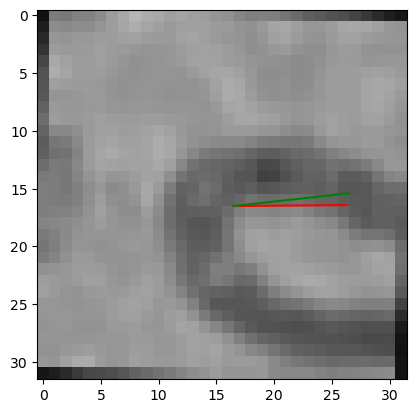

In [50]:
(img, act, exp, _, _) = d[300]
show_sa(img[0,:,:], exp, act[3,:])

In [51]:
td1 = DrivingDataset('data/assist-bc-noise-2.json', xform, name='td1')
print(td1)
td2 = DrivingDataset('data/inject-noise.json', xform, name='td2')
print(td2)
td3 = DrivingDataset('data/assist-dagger-fix.json', xform, name='td3')
print(td3)
td4 = DrivingDataset('data/assist-dagger-fix-2.json', xform, name='td4')
print(td4)
td5 = DrivingDataset('data/assist-dagger-fix-3.json', xform, name='td5')
print(td5)
td6 = DrivingDataset('data/assist-dagger-fix-4.json', xform, name='td6')
print(td6)
tst = DrivingDataset('data/driving-data-w-acts-ex.json', name='tst')
print(tst)
train_data = td.DataLoader(td.ConcatDataset([td1, td2, td3, td4, td5, td6]), batch_size = 64)
test_data = td.DataLoader(tst, batch_size = 64)

td1: 1119 frame groups in 19.346 s, 57.9965 fps avg
td2: 1458 frame groups in 24.291 s, 60.1457 fps avg
td3: 1053 frame groups in 17.593 s, 60.0239 fps avg
td4: 1092 frame groups in 18.195 s, 60.1814 fps avg
td5: 1020 frame groups in 16.99 s, 60.2119 fps avg
td6: 2333 frame groups in 39.041 s, 59.8345 fps avg
tst: 990 frame groups in 17.175 s, 57.8166 fps avg


In [52]:
# td1 = DrivingDataset('data/inject-noise-lag.json', xform, name='td1')
# # td1 = DrivingDataset('data/driving-data-w-acts-ex-2.json', xform, name='td1')
# print(td1)
# tst = DrivingDataset('data/driving-data-w-acts-ex.json', name='tst')
# train_data = td.DataLoader(td1, batch_size = 64)
# test_data = td.DataLoader(tst, batch_size = 64)

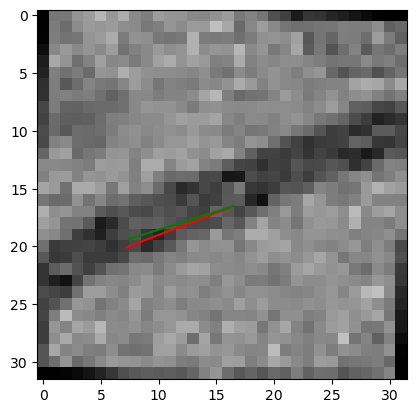

In [53]:
_, (img, act, exp, nse, aux) = enumerate(train_data).__next__()
t = 53
show_sa(img[t,0,:,:], exp[t,:], act[t,3,:])

In [54]:
# A linear network

# class Net(nn.Module):
    
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(5 * 32**2, 2)
    
#     def forward(self, x):
#         return self.fc1(torch.flatten(x, 1))
#         return x 

# net = Net()
# loss = F.mse_loss
# sgd = opt.SGD(net.parameters(), lr=0.001)

In [55]:
# simple network of relus with one hidden layer

# class Net(nn.Module):
    
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(5 * 32**2, 100)
#         self.fc2 = nn.Linear(100, 2)
    
#     def forward(self, x):
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x 

# net = Net()
# loss = F.mse_loss
# sgd = opt.SGD(net.parameters(), lr=0.001)

In [109]:
# An architecture similar to LeNet, except that the list of previous actions comes in at the first fully-connected layer

class Net(nn.Module):
    
    def __init__(self, nimg=5, nact=4, nout=2):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(nimg, 6, 5, padding=2)
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        self.fc1 = nn.Linear(576+2*nact, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, nout)
        self.nimg = nimg
        self.nact = nact
    
    def load_onnx(self, model):
        wts = { t.name: torch.tensor(onnx.numpy_helper.to_array(t)) for t in model.graph.initializer }
        self.load_state_dict(wts)

    def forward(self, *inputs): # x0, x1, x2, x3, x4, a0, a1, a2, a3):
        z = torch.stack(inputs[:self.nimg], dim=1)
        acts = torch.stack(inputs[self.nimg:], dim=1)
        # acts = torch.cat((a0, a1, a2, a3), dim=1)
        # z = torch.stack((x0, x1, x2, x3, x4), dim=1)
        return self.forward_stacked(z, acts)

    def forward_stacked(self, z, acts):
        z = F.relu(self.conv1(z))
        z = self.pool1(z)
        z = F.relu(self.conv2(z))
        z = self.pool2(z)
        # print(acts.shape)
        z = F.relu(self.fc1(torch.cat((torch.flatten(z, 1), torch.flatten(acts,1)), dim=1)))
        z = F.relu(self.fc2(z))
        return self.fc3(z), z

    # def forward_stacked(self, img, act):
    #     return self.forward(img[:,0,:,:], img[:,1,:,:], img[:,2,:,:], img[:,3,:,:], img[:,4,:,:], act[:,0,:], act[:,1,:], act[:,2,:], act[:,3,:])

net = Net()
loss = F.mse_loss
sgd = opt.SGD(net.parameters(), lr=0.001)

In [110]:
def train_one(net, img, act, exp, loss, opt):
    yhat, _ = net.forward_stacked(img, act)
    err = loss(yhat, exp)
    opt.zero_grad()
    err.backward()
    opt.step()
    return err.item() * img.shape[0], img.shape[0]

def train(dl, net, loss, opt, epochs=1):
    n = len(dl.dataset)
    for ep in range(epochs):
        ttl_err = 0
        ttl_ex = 0
        for _, (img, act, exp, _, _) in enumerate(dl):
            err, ex = train_one(net, img, act, exp, loss, opt)
            ttl_err += err
            ttl_ex += ex
            # yhat, _ = net.forward_stacked(img, act)
            # err = loss(yhat, exp)
            # opt.zero_grad()
            # err.backward()
            # opt.step()
            # ttl_err += err.item() * img.shape[0]
            # ttl_ex += img.shape[0]
        print(f"epoch: {ep:>5d}  loss: {ttl_err/ttl_ex:>7f}  processed: {ttl_ex:>5d}/{n}")

def test(dl, net, loss):
    with torch.no_grad():
        ttl_loss = 0
        ttl_ex = 0
        for _, (img, act, exp, _, _) in enumerate(dl):
            yhat, _ = net.forward_stacked(img, act)
            err = loss(yhat, exp).item()
            ttl_loss += err * img.shape[0]
            ttl_ex += img.shape[0]
        avg_loss = ttl_loss/ttl_ex
        print(f"loss: {avg_loss:>7f}")
        return avg_loss

def scatter(dl, net):
    with torch.no_grad():
        ys = []
        yhats = []
        for _, (img, act, exp, _, _) in enumerate(dl):
            yhat, _ = net.forward_stacked(img, act)
            ys.append(exp)
            yhats.append(yhat)
        ys = torch.cat(ys)
        yhats = torch.cat(yhats)
        fig = plt.plot(ys[:,0], yhats[:,0], 'k.', ys[:,1], yhats[:,1], 'b.')
        plt.ylabel('predicted')
        plt.xlabel('actual')
        plt.legend(['x', 'y'])
        return fig

loss: 48.943097


48.94309713960898

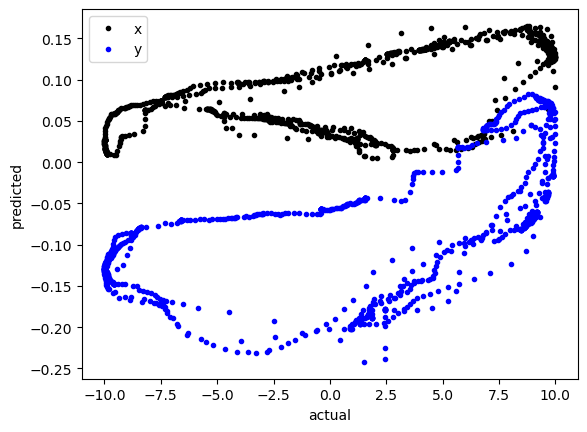

In [111]:
fig = scatter(test_data, net)
test(test_data, net, loss)

In [113]:
train(train_data, net, loss, sgd, epochs=4)

epoch:     0  loss: 20.536321  processed:  8075/8075
epoch:     1  loss: 5.681013  processed:  8075/8075
epoch:     2  loss: 5.670498  processed:  8075/8075
epoch:     3  loss: 5.657981  processed:  8075/8075


loss: 0.417463


0.41746344981771527

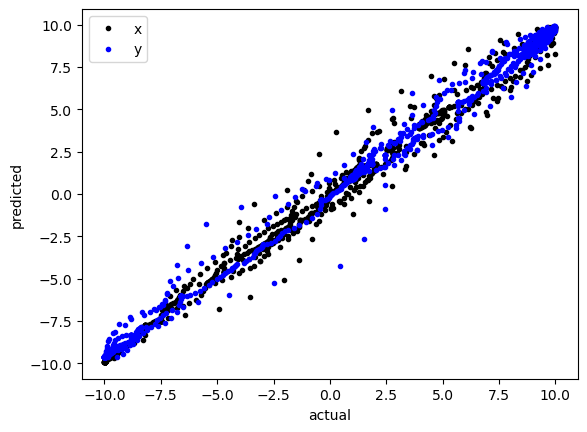

In [114]:
fig = scatter(test_data, net)
test(test_data, net, loss)

In [70]:
net.eval() # switch to inference mode
b = {0: 'batch_size'}
torch.onnx.export(net, 
    (img[:,0,:,:], img[:,1,:,:], img[:,2,:,:], img[:,3,:,:], img[:,4,:,:], act[:,0,:], act[:,1,:], act[:,2,:], act[:,3,:]), 
    'bc.onnx', 
    export_params=True, 
    do_constant_folding=True, 
    input_names=['f0', 'f1', 'f2', 'f3', 'f4', 'a0', 'a1', 'a2', 'a3'], 
    output_names=['act', 'embed'], 
    dynamic_axes={'f0': b, 'f1': b, 'f2': b, 'f3': b, 'f4': b, 'a0': b, 'a1': b, 'a2': b, 'a3': b, 'act': b, 'embed': b})

In [14]:
onnx_model = onnx.load('bc.onnx')
onnx.checker.check_model(onnx_model)

In [50]:
td4noxform = DrivingDataset('data/assist-dagger-2.json', transform=None, aux=1.)
selfdrive = DrivingDataset('data/self-drive-3.json', transform=None, aux=-1.)
net.load_onnx(onnx.load('models/dagger-fix-5.onnx'))
discrim_data = td.DataLoader(td.ConcatDataset([td4noxform, selfdrive]), batch_size = 64)

In [51]:
with torch.no_grad(): 
    Xexp = torch.stack([net.forward_stacked(imgs[None,:,:,:], act[None,:,:])[1][0] for (imgs, act, _, _, _) in td4noxform])
    Xself = torch.stack([net.forward_stacked(imgs[None,:,:,:], act[None,:,:])[1][0] for (imgs, act, _, _, _) in selfdrive])
    noises = torch.stack([nse for (_, _, _, nse, _) in selfdrive])
    policy_exp = torch.stack([exp for (_, _, exp, _, _) in td4noxform])
    policy_self = torch.stack([exp for (_, _, exp, _, _) in selfdrive])
    # pol2 = torch.stack([net.forward_stacked(imgs[None,:,:,:], act[None,:,:])[0][0] for (imgs, act, _, _, _) in selfdrive])
# nrms = pol2.norm(dim=1).reshape((-1, 1))
# nrms[nrms<10] = 10
# pol_norm = 10 * pol2 / nrms
Xexp = torch.concat((Xexp, torch.ones(Xexp.shape[0], 1)), dim=1)
Xself = torch.concat((Xself, torch.ones(Xself.shape[0], 1)), dim=1)

In [1]:
labels_self = {
    65: '1',
    66: '1',
    67: '1',
    68: '1',
    69: '1',
    70: '1',
    71: '1',
    72: '1',
    73: '1',
    74: '1',
    75: '1',
    76: '1',
    77: '1',
    78: '1'
}
labels_exp = {
    270: '2',
    271: '2',
    272: '2',
    273: '2',
    274: '2',
    275: '2',
    276: '2',
    277: '2',
    278: '2',
    279: '2',
    280: '2',
    281: '2',
    282: '2',
    283: '2',
    284: '2',
    285: '2',
    286: '2',
    287: '2',
    288: '2',
    289: '2',
    290: '2',
    291: '2',
    292: '2',
    293: '2',
    294: '2',
    295: '2',
    296: '2',
    297: '2',
    298: '2',
    299: '2',
    300: '2',
    301: '2'
}

In [124]:
td_rand = DrivingDataset('data/random.json.gz', xform, name='td_rand', swindow=4, awindow=4)
print(td_rand)

td_rand: 6541 frame groups in 109.086 s, 59.9802 fps avg


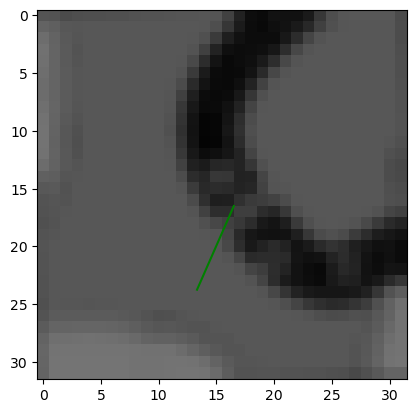

In [138]:
img, act, exp, _, _ = td_rand[7]
show_sa(img[0,:,:], exp, act[3,:])

In [140]:
act.shape

torch.Size([4, 2])

In [126]:
# hand labeled rewards for first part of random.json
# reward is class 2 if car is on road and action is forward at more than minimal speed, class 1 o/w
#  0: '1',
#  1: '1',
#  2: '1',
#  3: '1',
#  4: '1',
labels_reward = {
 5: '1',
 6: '1',
 7: '1',
 8: '1',
 9: '1',
 10: '1',
 11: '1',
 12: '1',
 13: '1',
 14: '1',
 15: '1',
 16: '2',
 17: '2',
 18: '2',
 19: '2',
 20: '2',
 21: '1',
 22: '1',
 23: '2',
 24: '1',
 25: '1',
 26: '1',
 27: '2',
 28: '1',
 29: '1',
 30: '1',
 31: '1',
 32: '1',
 33: '1',
 63: '1',
 64: '1',
 65: '1',
 66: '1',
 67: '1',
 68: '1',
 69: '1',
 70: '1',
 71: '1',
 72: '1',
 73: '1',
 74: '1',
 75: '1',
 76: '1',
 77: '1',
 78: '1',
 79: '1',
 80: '1',
 81: '1',
 82: '1',
 83: '1',
 84: '1',
 85: '1',
 144: '1',
 145: '1',
 146: '1',
 147: '1',
 148: '1',
 149: '1',
 150: '1',
 151: '1',
 152: '1',
 153: '1',
 154: '1',
 155: '1',
 156: '1',
 157: '1',
 158: '1',
 159: '1',
 160: '1',
 161: '1',
 162: '1',
 163: '1',
 164: '1',
 165: '1',
 166: '1',
 167: '1',
 168: '1',
 169: '1',
 170: '1',
 171: '1',
 172: '1',
 173: '1',
 174: '1',
 175: '1',
 176: '1',
 177: '1',
 178: '1',
 179: '1',
 180: '1',
 181: '1',
 182: '1',
 183: '1',
 184: '1',
 185: '1',
 186: '1',
 187: '1',
 188: '1',
 189: '1',
 190: '1',
 191: '1',
 192: '1',
 193: '1',
 194: '1',
 195: '1',
 196: '1',
 197: '1',
 198: '1',
 199: '1',
 200: '1',
 201: '1',
 202: '1',
 203: '1',
 204: '1',
 205: '1',
 206: '1',
 207: '1',
 208: '1',
 209: '1',
 210: '1',
 211: '1',
 212: '1',
 213: '1',
 214: '1',
 215: '1',
 216: '1',
 217: '1',
 218: '1',
 219: '1',
 220: '1',
 221: '1',
 222: '1',
 223: '1',
 224: '1',
 225: '1',
 226: '1',
 227: '1',
 228: '1',
 229: '1',
 230: '1',
 231: '1',
 232: '1',
 233: '1',
 234: '1',
 235: '1',
 236: '1',
 237: '1',
 238: '1',
 239: '1',
 240: '1',
 241: '1',
 242: '1',
 243: '1',
 244: '1',
 245: '1',
 246: '1',
 247: '1',
 248: '1',
 249: '1',
 250: '1',
 251: '1',
 280: '1',
 281: '1',
 282: '1',
 283: '1',
 284: '2',
 285: '2',
 286: '1',
 287: '1',
 288: '2',
 289: '1',
 290: '2',
 291: '2',
 292: '1',
 293: '1',
 294: '1',
 295: '1',
 296: '1',
 297: '1',
 298: '1',
 299: '1',
 300: '1',
 301: '1',
 302: '1',
 303: '1',
 304: '1',
 305: '1',
 306: '1',
 307: '1',
 308: '1',
 309: '1',
 310: '1',
 311: '1',
 312: '1',
 313: '1',
 314: '1',
 315: '1',
 316: '1',
 317: '1',
 318: '1',
 319: '1',
 320: '1',
 321: '1',
 322: '1',
 323: '1',
 324: '1',
 325: '2',
 326: '2',
 327: '2',
 328: '2',
 329: '1',
 330: '1',
 331: '1',
 332: '1',
 333: '1',
 334: '1',
 335: '1',
 336: '1',
 337: '1',
 338: '1',
 339: '1',
 340: '1',
 341: '1',
 342: '1',
 343: '1',
 344: '1',
 345: '1',
 346: '1',
 347: '1',
 348: '1',
 349: '1',
 350: '1',
 351: '1',
 352: '1',
 353: '1',
 354: '2',
 355: '2',
 356: '1',
 357: '1',
 358: '1',
 359: '2',
 360: '1',
 361: '1',
 362: '1',
 363: '1',
 364: '1',
 365: '1',
 366: '1',
 367: '1',
 368: '1',
 369: '1',
 370: '1',
 371: '1',
 372: '1',
 373: '1',
 374: '1',
 375: '1',
 376: '1',
 377: '1',
 378: '1',
 379: '1',
 380: '1',
 381: '1',
 382: '1',
 383: '1',
 384: '1',
 385: '1',
 386: '1',
 387: '1',
 388: '1',
 389: '1',
 390: '1',
 391: '1',
 392: '1',
 393: '2',
 394: '2',
 395: '2',
 396: '2',
 397: '2',
 398: '2',
 399: '2',
 400: '2',
 401: '2',
 402: '2',
 403: '2',
 404: '2',
 405: '2',
 406: '2',
 407: '2',
 408: '2',
 409: '2',
 410: '2',
 411: '2',
 412: '2',
 413: '2',
 414: '2',
 416: '1',
 417: '1',
 418: '1',
 419: '1',
 420: '1',
 421: '2',
 422: '2',
 423: '2',
 424: '2',
 425: '1',
 426: '1',
 427: '1',
 428: '1',
 429: '1',
 430: '1',
 431: '1',
 432: '1',
 433: '1',
 434: '1',
 435: '1',
 436: '1',
 437: '1',
 438: '1',
 439: '1',
 440: '1',
 441: '1',
 442: '1',
 443: '1',
 444: '1',
 445: '1',
 446: '1',
 447: '1',
 448: '1',
 449: '1',
 450: '1',
 451: '1',
 452: '1',
 453: '1',
 454: '1',
 455: '1',
 456: '1',
 457: '1',
 458: '1',
 459: '1',
 460: '1',
 461: '1',
 462: '1',
 463: '1',
 464: '1',
 465: '1',
 466: '1',
 467: '1',
 468: '1',
 469: '1',
 470: '1',
 471: '1',
 472: '1',
 473: '1',
 474: '1',
 475: '1',
 476: '1',
 477: '1',
 478: '1',
 479: '1',
 480: '1',
 481: '1',
 482: '1',
 483: '1',
 484: '1',
 485: '1',
 486: '1',
 487: '1',
 488: '1',
 489: '1',
 490: '1',
 491: '1',
 492: '1',
 493: '1',
 494: '1',
 495: '1',
 496: '1',
 497: '1',
 498: '1',
 499: '1',
 500: '1',
 501: '1',
 502: '1',
 503: '1',
 504: '1',
 505: '1',
 506: '1',
 507: '1',
 508: '1',
 509: '1',
 510: '1',
 511: '1',
 512: '1',
 513: '1',
 514: '1',
 515: '1',
 516: '1',
 517: '1',
 518: '1',
 519: '1',
 520: '1',
 521: '1',
 522: '1',
 523: '1',
 524: '1',
 525: '1',
 526: '1',
 527: '1',
 528: '1',
 529: '1',
 530: '1',
 531: '1',
 532: '1',
 533: '1',
 534: '1',
 535: '1',
 536: '1',
 537: '1',
 538: '1',
 539: '1',
 540: '1',
 541: '1',
 542: '1',
 543: '1',
 544: '1',
 545: '1',
 546: '1',
 547: '1',
 548: '1',
 549: '1',
 550: '1',
 551: '1',
 552: '1',
 553: '1',
 554: '1',
 555: '1',
 556: '1',
 557: '1',
 558: '1',
 559: '1',
 560: '1',
 561: '1',
 562: '1',
 563: '1',
 564: '1',
 565: '1',
 566: '1',
 567: '1',
 568: '1',
 569: '1',
 570: '1',
 571: '1',
 572: '1',
 573: '1',
 574: '1',
 575: '1',
 576: '1',
 577: '1',
 578: '1',
 579: '1',
 580: '1',
 581: '1',
 582: '1',
 583: '1',
 584: '2',
 585: '2',
 586: '2',
 587: '2',
 588: '1',
 589: '1',
 590: '1',
 591: '1',
 592: '1',
 593: '2',
 594: '1',
 595: '1',
 596: '1',
 597: '1',
 598: '1',
 599: '1',
 600: '1',
 601: '1',
 602: '1',
 603: '1',
 604: '2',
 605: '2',
 606: '1',
 607: '1',
 608: '1',
 609: '1',
 610: '1',
 611: '1',
 612: '1',
 613: '1',
 614: '1',
 615: '1',
 616: '1',
 617: '1',
 618: '1',
 619: '1',
 620: '1',
 621: '1',
 622: '1',
 623: '1',
 624: '1',
 625: '1',
 626: '1',
 627: '1',
 628: '1',
 629: '1',
 630: '1',
 631: '1',
 632: '1',
 633: '1',
 634: '1',
 635: '1',
 636: '1',
 637: '1',
 638: '1',
 639: '1',
 640: '1',
 641: '1',
 642: '1',
 643: '1',
 644: '1',
 645: '1',
 646: '1',
 647: '1',
 648: '1',
 649: '1',
 650: '1',
 651: '1',
 652: '1',
 653: '1',
 654: '1',
 655: '1',
 656: '1',
 657: '1',
 658: '1',
 659: '1',
 660: '1',
 661: '1',
 662: '1',
 663: '1',
 664: '1',
 665: '1',
 666: '1',
 667: '1',
 668: '1',
 669: '1',
 670: '1',
 671: '1',
 672: '1',
 673: '1',
 674: '1',
 675: '1',
 676: '1',
 677: '1',
 678: '1',
 679: '1',
 680: '1',
 681: '1',
 682: '1',
 683: '1'}

In [127]:
# Wraps a DrivingDataset to predict rewards instead of actions

class RewardsDataset(td.Dataset):

    def __init__(self, driv, rewards, classmap):
        self.driving = driv
        self.rewards = rewards
        self.indices = [*rewards.keys()]
        self.offset = self.driving.swindow - 1
        self.classmap = classmap

    def __str__(self):
        return "r " + str(self.driving)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        imgs, act, _, _, _ = self.driving[idx-self.offset]
        r = self.classmap[self.rewards[idx]]
        return imgs, act, r


In [128]:
rd = RewardsDataset(td_rand, labels_reward, {'1':0, '2':1})
rdl = td.DataLoader(rd, batch_size=64)
net = Net(nimg=4, nact=4, nout=2)
loss = F.cross_entropy
sgd = opt.SGD(net.parameters(), lr=0.001)

tensor(0)

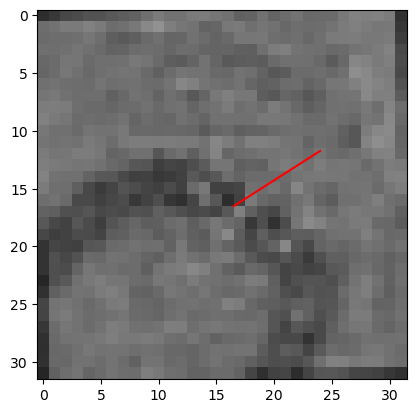

In [129]:
_, (img, act, rs) = enumerate(rdl).__next__()
t = 7
show_sa(img[t,0,:,:], act[t,3,:])
rs[t]

In [130]:
img.shape

torch.Size([64, 4, 32, 32])

In [160]:
def train_one(net, img, act, rs, loss, opt):
    yhat, _ = net.forward_stacked(img, act)
    err = loss(yhat, rs)
    opt.zero_grad()
    err.backward()
    opt.step()
    return err.item() * img.shape[0], img.shape[0]

def train(dl, net, loss, opt, epochs=1):
    n = len(dl.dataset)
    for ep in range(epochs):
        ttl_err = 0
        ttl_ex = 0
        for _, (img, act, rs) in enumerate(dl):
            err, ex = train_one(net, img, act, rs, loss, opt)
            ttl_err += err
            ttl_ex += ex
        print(f"epoch: {ep:>5d}  loss: {ttl_err/ttl_ex:>7f}  processed: {ttl_ex:>5d}/{n}")


In [173]:
train(rdl, net, loss, sgd, epochs=2000)

epoch:     0  loss: 0.154378  processed:   563/563
epoch:     1  loss: 0.157763  processed:   563/563
epoch:     2  loss: 0.149178  processed:   563/563
epoch:     3  loss: 0.143167  processed:   563/563
epoch:     4  loss: 0.146489  processed:   563/563
epoch:     5  loss: 0.146924  processed:   563/563
epoch:     6  loss: 0.136975  processed:   563/563
epoch:     7  loss: 0.153310  processed:   563/563
epoch:     8  loss: 0.147917  processed:   563/563
epoch:     9  loss: 0.138257  processed:   563/563
epoch:    10  loss: 0.147860  processed:   563/563
epoch:    11  loss: 0.142681  processed:   563/563
epoch:    12  loss: 0.159807  processed:   563/563
epoch:    13  loss: 0.145696  processed:   563/563
epoch:    14  loss: 0.127652  processed:   563/563
epoch:    15  loss: 0.127159  processed:   563/563
epoch:    16  loss: 0.142915  processed:   563/563
epoch:    17  loss: 0.151284  processed:   563/563
epoch:    18  loss: 0.138709  processed:   563/563
epoch:    19  loss: 0.140363  p

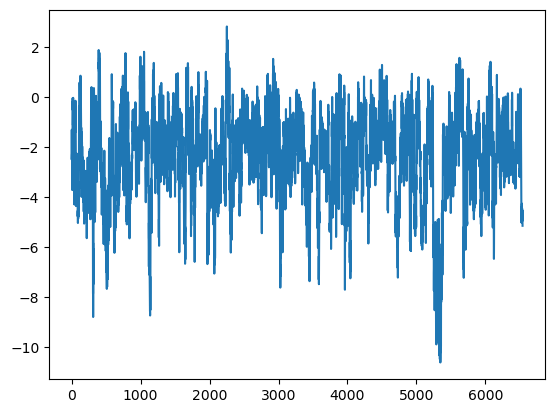

In [174]:
with torch.no_grad():
    pred_reward = [net.forward_stacked(img[None,:,:,:], act[None,:,:])[0] for img, act, _, _, _ in td_rand]
pred_reward = torch.concat(pred_reward) @ torch.tensor([-.5, .5])
plt.plot(pred_reward)

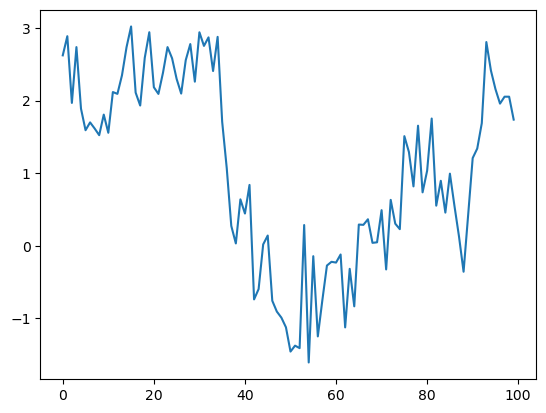

In [171]:
plt.plot(pred_reward[2200:2300])

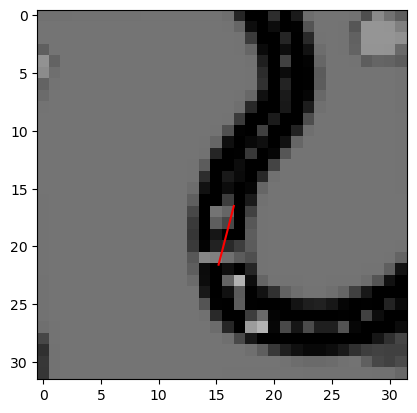

In [172]:
img, act, _, _, _ = td_rand[2350]
show_sa(img[3,:,:], act[3,:])


In [53]:
randfeat = 300
sig = .1
nstate = Xexp.shape[-1]
W_state = torch.randn((nstate, randfeat))*sig
b_state = torch.rand(randfeat) * 2 * math.pi

rf_act = 15
sig_act = .0005
W_act = torch.randn((2, rf_act))*sig_act
b_act = torch.rand(rf_act) * 2 * math.pi

def rff(X, W, b):
    return torch.sin(X @ W + b)/math.sqrt(0.5*randfeat)

embed_self = rff(Xself, W_state, b_state)
embed_exp = rff(Xexp, W_state, b_state)

embed_act_self = rff(policy_self, W_act, b_act)
embed_act_exp = rff(policy_exp, W_act, b_act)


In [54]:
# selfmean = torch.mean(embed_self[list(labels_self),:], dim=0)
# expmean = torch.mean(embed_exp[list(labels_exp),:], dim=0)

# def discrim(X):
#     ker = 40
#     z = torch.exp(-0.5*ker*((X - selfmean)**2).sum(dim=1))
#     z -= torch.exp(-0.5*ker*((X - expmean)**2).sum(dim=1))
#     return z

In [55]:
# selfmean = torch.mean(Xself[list(labels_self),:], dim=0)
# expmean = torch.mean(Xexp[list(labels_exp),:], dim=0)
# def discrim(X):
#     return X @ selfmean - X @ expmean

In [56]:
# rng = range(0, 1000)
# plt.plot(discrim(Xself[rng,:]))
# plt.plot(discrim(Xexp[rng,:]))

In [57]:
# rng = range(50, 300)
# plt.plot(discrim(embed_self[rng,:]))
# plt.plot(discrim(embed_exp[rng,:]))

In [58]:
# khatri-rao (row-wise kronecker) product
def kr(X, Y):
    return (X.unsqueeze(2) * Y.unsqueeze(1)).flatten(1,-1)

# adjoin a column of 1s
def cat1(X):
    return torch.cat((torch.ones((X.shape[0],1)), X), dim=1)

# quadratic features of 2d vectors
def qf(X):
    z = cat1(X)
    z = kr(z, z)
    return z[:, (0, 1, 2, 4, 5, 8)]


In [59]:
# quadratic action features
# z = cat1(policy_exp[:-1,:])
# z = kr(z, z)
# from_act_exp = z[:, (0, 1, 2, 4, 5, 8)]
# z = cat1(policy_self[:-1,:])
# z = kr(z, z)
# from_act_self = z[:, (0, 1, 2, 4, 5, 8)]

from_act_exp = qf(policy_exp[:-1,:])
from_act_self = qf(policy_self[:-1,:])

# random fourier features for actions
# from_act_self = embed_act_self[:-1,:]
# from_act_exp = embed_act_exp[:-1,:]

# linear action features
# from_act_exp = cat1(policy_exp[:-1,:])
# from_act_self = cat1(policy_self[:-1,:])

In [60]:
from_self = embed_self[:-1,:]
to_self = embed_self[1:,:]
from_exp = embed_exp[:-1,:]
to_exp = embed_exp[1:,:]
# from_all = torch.cat((from_self * from_act_self, from_exp * from_act_exp))
from_all = torch.cat((kr(from_self, from_act_self), kr(from_exp, from_act_exp)))
# from_all = torch.cat((from_self, from_exp))
to_all = torch.cat((to_self, to_exp))
split = torch.randperm(from_all.shape[0])
tr = split[:1500]
te = split[1500:]
from_all_tr = from_all[tr,:]
from_all_te = from_all[te,:]
to_all_tr = to_all[tr,:]
to_all_te = to_all[te,:]
trans = torch.linalg.solve(from_all_tr.t() @ from_all_tr + .1*torch.eye(from_all_tr.shape[1]), from_all_tr.t() @ to_all_tr)

In [61]:
(to_all_te - from_all_te @ trans).norm()/math.sqrt(to_all_te.shape[0])

tensor(0.0206)

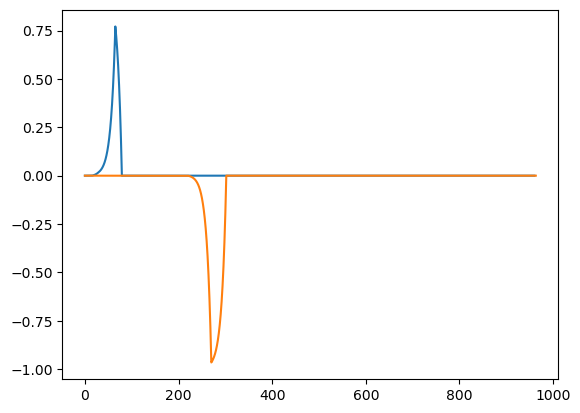

In [62]:
H = 50
lam = 0.9

Rself = torch.zeros((embed_self.shape[0], 1))
Rself[list(labels_self),:] = 1
Vself = 0
for t in range(H):
    Vself += (1-lam) * lam**t * Rself[t:-H+t]
plt.plot(Vself)

# Rt = discrim(embed_exp)
Rexp = torch.zeros((embed_exp.shape[0], 1))
Rexp[list(labels_exp),:] = -1
Vexp = 0
for t in range(H):
    Vexp += (1-lam) * lam**t * Rexp[t:-H+t]
plt.plot(Vexp)

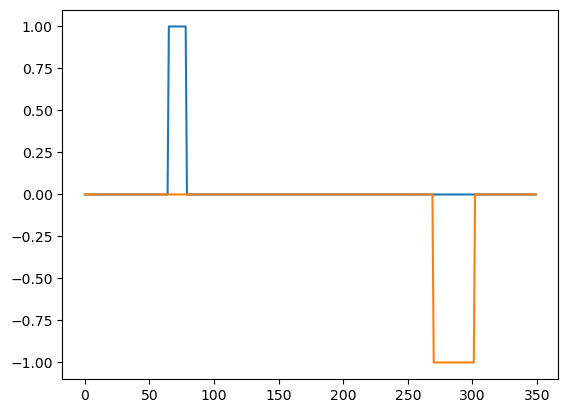

In [63]:
rng = range(0, 350)
plt.plot(Rself[rng,:])
plt.plot(Rexp[rng,:])

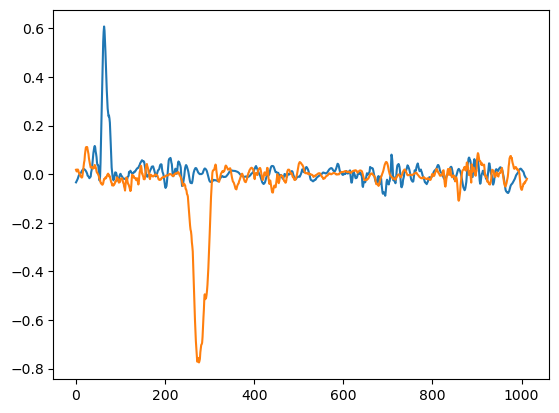

In [64]:
ridge = .1
nself = Vself.shape[0]
nexp = Vexp.shape[0]
nfeat = from_self.shape[1]
X = torch.cat((from_self[:nself,:], from_exp[:nexp,:]))
y = torch.cat((Vself, Vexp))
V_weights = torch.linalg.solve(X.t()@X + ridge*torch.eye(nfeat), X.t()@y)
plt.plot(from_self @ V_weights)
plt.plot(from_exp @ V_weights)

In [65]:
def train_one_dpg(net, img, act, opt):
    policy, _ = net.forward_stacked(img, act)
    _, state = net_froz.forward_stacked(img, act)
    embed_s = torch.sin(cat1(state) @ W_state + b_state)/math.sqrt(0.5*randfeat)
    embed_a = qf(policy)
    next_state = kr(embed_s, embed_a) @ trans
    est_value = 0.5 * (next_state @ V_weights).mean()
    opt.zero_grad()
    est_value.backward()
    opt.step()
    return est_value.item() * img.shape[0], img.shape[0]

def train_dpg(dl, net, opt, epochs=1):
    n = len(dl.dataset)
    for ep in range(epochs):
        ttl_val = 0
        ttl_ex = 0
        for _, (img, act, exp, _, _) in enumerate(dl):
            val, ex = train_one_dpg(net, img, act, opt)
            ttl_val += val
            ttl_ex += ex
            # policy, state = net.forward_stacked(img, act)
            # # print(policy.shape, state.shape, policy[0,0], state[0,0])
            # embed_s = torch.sin(cat1(state) @ W_state + b_state)/math.sqrt(0.5*randfeat)
            # embed_a = qf(policy)
            # # print(embed_s.shape, embed_a.shape, embed_s[0,0], embed_a[0,0])
            # next_state = kr(embed_s, embed_a) @ trans
            # est_value = 0.2 * (next_state @ V_weights).mean()
            # opt.zero_grad()
            # est_value.backward()
            # opt.step()
            # ttl_val += est_value.item() * img.shape[0]
            # ttl_ex += img.shape[0]
        print(f"epoch: {ep:>5d}  value: {ttl_val/ttl_ex:>7f}  processed: {ttl_ex:>5d}/{n}")

def train_together(dl_im, dl_val, net, opt, epochs=1):
    n_im = len(dl_im.dataset)
    n_val = len(dl_val.dataset)
    p = n_im / (n_val + n_im)
    ttl_val_im = 0
    ttl_ex_im = 0
    ttl_val_val = 0
    ttl_ex_val = 0
    for ep in range(epochs):
        enum_im = enumerate(dl_im)
        enum_val = enumerate(dl_val)
        done_im = False
        done_val = False
        while not (done_im and done_val):
            if torch.rand(1).item() < p:
                try:
                    _, (img, act, exp, _, _) = enum_im.__next__()
                    val, ex = train_one(net, img, act, exp, opt)
                    ttl_val_im += val
                    ttl_ex_im += ex
                except StopIteration:
                    done_im = True
            else:
                try:
                    _, (img, act, _, _, _) = enum_val.__next__()
                    val, ex = train_one_dpg(net, img, act, opt)
                    ttl_val_val += val
                    ttl_ex_val += ex
                except StopIteration:
                    done_val = True
        print(f"epoch: {ep:>5d}  value im: {ttl_val_im/ttl_ex_im:>7f}  value val: {ttl_val_val/ttl_ex_val:>7f}")


In [120]:
net = Net()
net_froz = Net()
onx = onnx.load('models/dagger-fix-5.onnx')
net.load_onnx(onx)
net_froz.load_onnx(onx)
net_froz.eval()

Net(
  (conv1): Conv2d(5, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=584, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [121]:
# net.load_onnx(onnx.load('models/dagger-fix-5.onnx'))
with torch.no_grad(): 
    pol_before = torch.stack([net.forward_stacked(imgs[None,:,:,:], act[None,:,:])[0][0] for (imgs, act, _, _, _) in selfdrive])

In [122]:
# train_together(train_data, discrim_data, net, opt.SGD(net.parameters(), lr=0.00005), epochs=2)

In [123]:
train_dpg(discrim_data, net, opt.SGD(net.parameters(), lr=0.00005), epochs=2)

epoch:     0  value: -0.081413  processed:  2025/2025
epoch:     1  value: -0.083820  processed:  2025/2025


In [116]:
# for i in range(3):
#     train_dpg(discrim_data, net, opt.SGD(net.parameters(), lr=0.001), epochs=4)
#     train(train_data, net, loss, opt.SGD(net.parameters(), lr=0.001), epochs=1)

In [124]:
with torch.no_grad(): 
    pol_after = torch.stack([net.forward_stacked(imgs[None,:,:,:], act[None,:,:])[0][0] for (imgs, act, _, _, _) in selfdrive])

In [125]:
(pol_before - pol_after).norm()

tensor(3.8303)

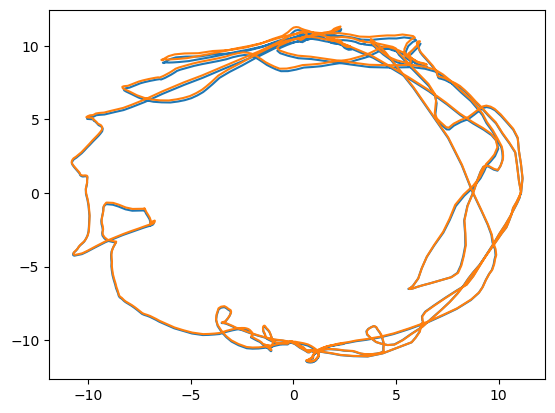

In [126]:
plt.plot(pol_before[:,0], pol_before[:,1])
plt.plot(pol_after[:,0], pol_after[:,1])

In [ ]:
# plt.plot(torch.stack((pol_before[:,0], pol_after[:,0]), dim=1), torch.stack((pol_before[:,1], pol_after[:,1]), dim=1))

In [ ]:
V_weights.shape

In [ ]:
X = torch.concat([Xexp, Xself])
y = torch.concat([torch.ones(Xexp.shape[0], 1), -torch.ones(Xself.shape[0], 1)])

In [ ]:
pw = torch.concat([net.state_dict()['fc3.weight'].t(), net.state_dict()['fc3.bias'].reshape((1, 2))])
# pw = torch.linalg.solve(Xself.t() @ Xself + 1e-15 * torch.eye(Xself.shape[1]), Xself.t() @ pol2)

In [ ]:
changes = (Xself @ (Xself[:-H,:].t() @ ((Vself - Vself.mean()) * noises[:-H,:]))) / Vself.shape[0]
plt.plot(changes[:,0])
plt.plot(changes[:,1])


In [ ]:
(pol2[0:-1,:] - policy[1:,:]).norm()/math.sqrt(pol2.shape[0]-1)

In [ ]:
pol_norm[100:117,:]

In [ ]:
policy[100:117,:]

In [ ]:
plt.plot(pol_norm[:,0])
plt.plot(policy[:,0])
plt.plot(pol_norm[:,1])
plt.plot(policy[:,1])
plt.legend(['pol2 x', 'policy x', 'pol2 y', 'policy y'])


In [ ]:
ridge = 100
w = torch.linalg.solve(X.t() @ X + ridge * torch.eye(X.shape[1]), X.t() @ y)
yhat = X@w
plt.plot(yhat, y+torch.randn(y.shape)*.3, '.')
f"weight norm: {torch.linalg.vector_norm(w).item():.5}"

In [ ]:
yhatself = Xself @ w
H = 50
lam = 0.9
Vself = 0
for t in range(H):
    Vself += (1-lam) * lam**t * yhatself[t:-H+t,:]
plt.plot(Vself)

In [ ]:
plt.plot(yhat)
H = 50
lam = 0.9
V = 0
for t in range(H):
    V += (1-lam) * lam**t * yhat[t:-H+t,:]
plt.plot(V)


In [ ]:
yclip = y[:-H]
plt.plot(V, yclip+torch.randn(yclip.shape)*.3, '.')

In [ ]:
plt.plot(V[150:300,:])

In [ ]:
(im, _, _, _, _) = selfdrive[1915 - Xexp.shape[0]]
plt.imshow(1-im[4,:,:], 'Greys', vmin=0, vmax=1)

In [ ]:
(im, _, _, _, _) = td4noxform[170]
plt.imshow(1-im[4,:,:], 'Greys', vmin=0, vmax=1)

In [ ]:
gam = 0.75
ridge = 10
T = 10
lam = .7
Xe = X[:nexpert-T,:]
Xs = X[nexpert:-T,:]
XTX = 0
XTy = 0
for t in range(T):
    Xe_shift = X[t+1:nexpert-T+t+1,:]
    Xs_shift = X[nexpert+t+1:nexpert+nself-T+t+1,:]
    # print(f"{Xe_shift.shape} {Xs_shift.shape}")
    incr = Xe.t() @ (Xe - gam**t * Xe_shift)
    incr += Xs.t() @ (Xs - gam**t * Xs_shift)
    XTX += lam**t * incr
    sumgam = gam**t * (1/(1-lam) - 1/(1-lam**(T-t)))
    XTy += sumgam * (Xe.t() @ yhat[t:nexpert-T+t] + Xs.t() @ yhat[nexpert+t:nexpert+nself-T+t])
XTy *= (1-gam)/(1-gam**T)
critic_w = torch.linalg.solve(XTX + ridge * torch.eye(85), XTy)
yhat_critic = X @ critic_w

In [ ]:
# norms_td4 = torch.linalg.vector_norm(embed_td4, dim=1).reshape((-1,1))
# norms_sd = torch.linalg.vector_norm(embed_sd, dim=1).reshape((-1,1))
# d2s = norms_td4**2 + norms_sd.t()**2 - 2 * embed_td4 @ embed_sd.t()
# gram = torch.exp(-0.05*d2s)
# plt.imshow(gram)
# # plt.colorbar()

In [ ]:
# ttl = 0
# ttlwt = 0
# for i in range(len(norms)):
#     (im, _, _) = td4noxform[i]
#     wt = gram[190, i]
#     ttl += wt * im[4,:,:]
#     ttlwt += wt
# plt.imshow(1-ttl/ttlwt, 'Greys', vmin=0, vmax=1)